# Limpieza de datos : seleccionando periodos con datos completos

En este notebook se procede a eliminar los periodos con valores nulos cuyo rango sea superior a una semana.

Este proceso se debe realizar semana por semana.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as os

df = pd.read_csv('data_gdc/gdc_2006_2024_horapunto.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158052 entries, 0 to 158051
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fhora           158052 non-null  object 
 1   identificacion  158052 non-null  int64  
 2   ddd             158052 non-null  float64
 3   dddstd          158052 non-null  int64  
 4   dddx            158052 non-null  int64  
 5   hr              158052 non-null  int64  
 6   lluv            114167 non-null  float64
 7   pres            119874 non-null  float64
 8   temp            106922 non-null  float64
 9   ts              104754 non-null  float64
 10  vel             125008 non-null  float64
 11  velx            124626 non-null  float64
 12  qdato           158052 non-null  int64  
dtypes: float64(7), int64(5), object(1)
memory usage: 15.7+ MB


In [27]:
def periodo_not_null(dataframe : pd.DataFrame, target: str,  period: int) -> pd.DataFrame():
    """
    Elimina las filas donde haya `period` o más valores nulos consecutivos.
    
    Parámetros:
    - dataframe: Se espera recibir una Serie de pandas con la columna que interese limpiar.
    - target: Nombre de la columna a limpiar.
    - period: Número entero que indica el máximo periodo de valores nulos consecutivos permitidos.

    Retorna:
    - DataFrame sin filas donde haya valores nulos consecutivos que excedan el valor de `period`.

    Nota:
    - period viene definido por la cantidad de registros consecutivos. 
    Si existe un registro para cada hora y queremos fijar un periodo de 1 semana, entonces period = 7 * 24.
    """
    
    # Crear una serie booleana donde True indica que toda la fila es nula
    is_null = dataframe[target].isnull()
    
    # Calcular las rachas (streaks) de valores nulos consecutivos
    streaks = is_null.groupby((is_null != is_null.shift()).cumsum()).cumsum()
    
    # Crear una máscara para identificar rachas que excedan o igualen el periodo
    mask = (streaks >= period) & is_null
    
    # Eliminar las filas donde las rachas de valores nulos excedan el periodo permitido
    dataframe_clean = dataframe.loc[~mask]
    
    return dataframe_clean

In [60]:
df_seleccionado = df[['fhora','temp']]
target = 'temp'
period = 7*24

df_sin_nulos = periodo_not_null(df_seleccionado, target, period)


df.isnull().sum()

print('Dataframe original: ', df['temp'].isnull().sum(), '\n', 'Dataframe sin nulos: ', df_sin_nulos['temp'].isnull().sum())

Dataframe original:  51130 
 Dataframe sin nulos:  5936


In [61]:
df_seleccionado = df_seleccionado.set_index('fhora')
df_sin_nulos = df_sin_nulos.set_index('fhora')

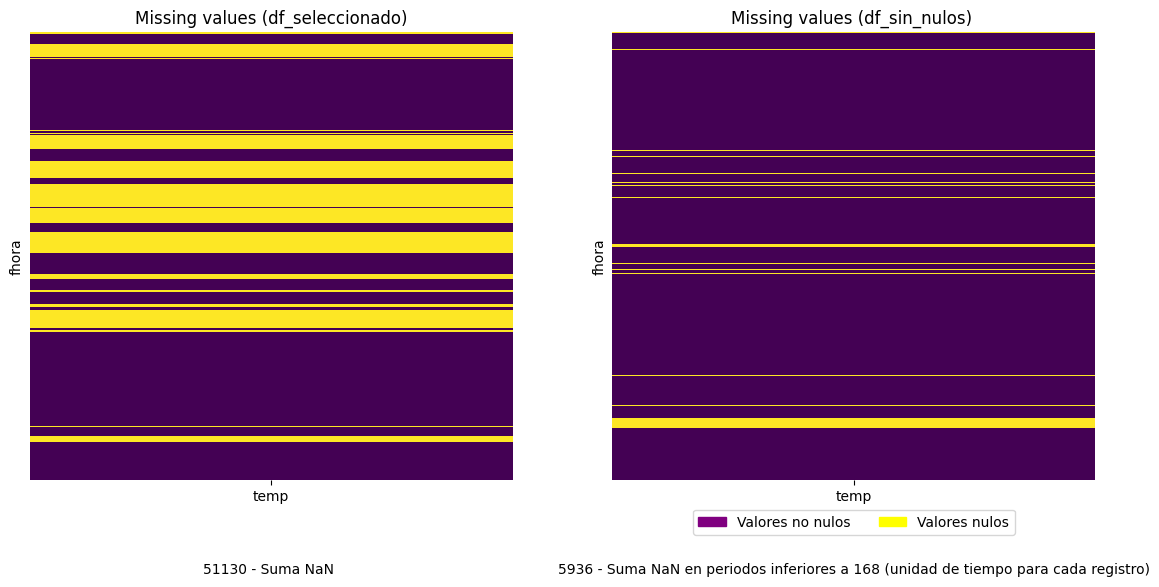

In [65]:
import matplotlib.patches as mpatches

# Crear una figura con dos subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Primer gráfico: df_seleccionado
sns.heatmap(df_seleccionado[['temp']].isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[0])
axes[0].set_title(f'Missing values (df_seleccionado)')
axes[0].text(0.5, -0.2, f'{df_seleccionado["temp"].isnull().sum()} - Suma NaN ', 
             ha='center', va='center', transform=axes[0].transAxes)

# Segundo gráfico: df_sin_nulos
sns.heatmap(df_sin_nulos[['temp']].isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[1])
axes[1].set_title(f'Missing values (df_sin_nulos) ')
axes[1].text(0.5, -0.2, f'{df_sin_nulos["temp"].isnull().sum()} - Suma NaN en periodos inferiores a {period} (unidad de tiempo para cada registro)', 
             ha='center', va='center', transform=axes[1].transAxes)


# Añadir la leyenda
null_patch = mpatches.Patch(color='purple', label='Valores no nulos')  # Ajustar el color según el mapa de colores usado
non_null_patch = mpatches.Patch(color='yellow', label='Valores nulos')  # Ajustar el color según el mapa de colores usado
plt.legend(handles=[null_patch, non_null_patch], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Ajustar el espacio entre los gráficos para que no se solapen
plt.tight_layout()